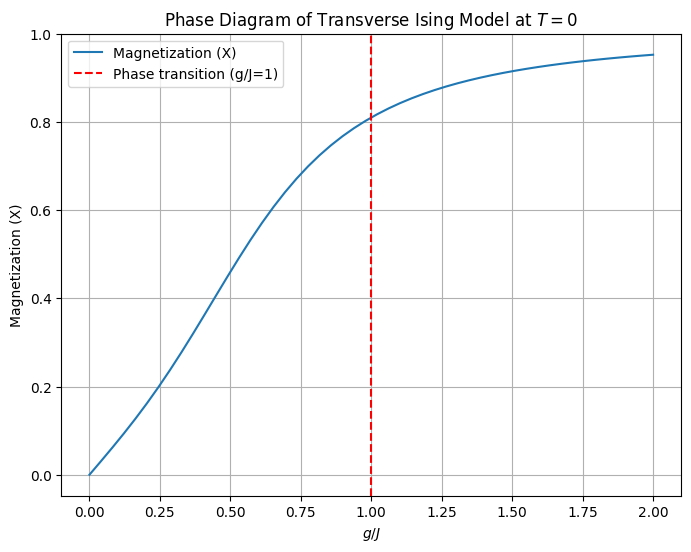

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# Pauli matrices
pauli_x = np.array([[0, 1], [1, 0]])
pauli_z = np.array([[1, 0], [0, -1]])
identity = np.eye(2)

def kronecker_product(operators):
    """Compute the Kronecker product for a list of operators."""
    result = operators[0]
    for op in operators[1:]:
        result = np.kron(result, op)
    return result

def construct_ising_hamiltonian(num_qubits, g, J):
    """Construct the Hamiltonian for the transverse Ising model."""
    H = np.zeros((2**num_qubits, 2**num_qubits))

    # ZZ interaction terms (nearest neighbor)
    for i in range(num_qubits - 1):
        operators = [identity] * num_qubits
        operators[i] = pauli_z
        operators[i + 1] = pauli_z
        H += -J * kronecker_product(operators)

    # X transverse field terms
    for i in range(num_qubits):
        operators = [identity] * num_qubits
        operators[i] = pauli_x
        H += -g * kronecker_product(operators)

    return H

def compute_magnetization(ground_state, num_qubits):
    """Compute the magnetization in the X direction."""
    magnetization_x = 0
    for i in range(num_qubits):
        operators = [identity] * num_qubits
        operators[i] = pauli_x
        x_op = kronecker_product(operators)
        magnetization_x += np.real(np.vdot(ground_state, x_op @ ground_state))

    return magnetization_x / num_qubits

def phase_diagram_transverse_ising(num_qubits, g_values, J):
    """Calculate magnetization for different values of g/J."""
    magnetizations = []

    for g in g_values:
        # Construct the Hamiltonian matrix
        H = construct_ising_hamiltonian(num_qubits, g, J)

        # Diagonalize the Hamiltonian to get the ground state
        eigvals, eigvecs = eigh(H)  # eigh for symmetric (Hermitian) matrices
        ground_state = eigvecs[:, 0]  # Ground state corresponds to the lowest eigenvalue

        # Compute the magnetization in the X direction
        magnetization_x = compute_magnetization(ground_state, num_qubits)
        magnetizations.append(magnetization_x)

    return magnetizations

# Parameters
num_qubits = 4  # Number of spins
J = 1.0         # Coupling constant
g_values = np.linspace(0, 2, 50)  # Range of g values (g/J)

# Compute magnetization for different g/J values
magnetizations = phase_diagram_transverse_ising(num_qubits, g_values, J)

# Plot the phase diagram
plt.figure(figsize=(8, 6))
plt.plot(g_values / J, magnetizations, label="Magnetization (X)")
plt.axvline(1, color='r', linestyle='--', label='Phase transition (g/J=1)')
plt.xlabel(r'$g/J$')
plt.ylabel('Magnetization (X)')
plt.title('Phase Diagram of Transverse Ising Model at $T=0$')
plt.legend()
plt.grid(True)
plt.show()



In [2]:
pip install qiskit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 7.7 MB/s eta 0:00:00


In [5]:
pip install qiskit-algorithms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 5.8 MB/s eta 0:00:00


VQE minimum energy for g/J=0.1: -3.0038553861214106
Magnetization for g/J=0.1: 0.017509339127252506
VQE minimum energy for g/J=0.13877551020408163: -3.02431951160328
Magnetization for g/J=0.13877551020408163: 0.09658512433280178
VQE minimum energy for g/J=0.17755102040816328: -3.0462346422127773
Magnetization for g/J=0.17755102040816328: 0.13142637064974655
VQE minimum energy for g/J=0.2163265306122449: -3.070073638602384
Magnetization for g/J=0.2163265306122449: 0.16239959874730733
VQE minimum energy for g/J=0.25510204081632654: -3.097535544890998
Magnetization for g/J=0.25510204081632654: 0.19101359704687837
VQE minimum energy for g/J=0.29387755102040813: -3.1293889761183786
Magnetization for g/J=0.29387755102040813: 0.21983148403245784
VQE minimum energy for g/J=0.3326530612244898: -3.1657509357291103
Magnetization for g/J=0.3326530612244898: 0.2487511189825189
VQE minimum energy for g/J=0.37142857142857144: -3.204827438268816
Magnetization for g/J=0.37142857142857144: 0.27915575921

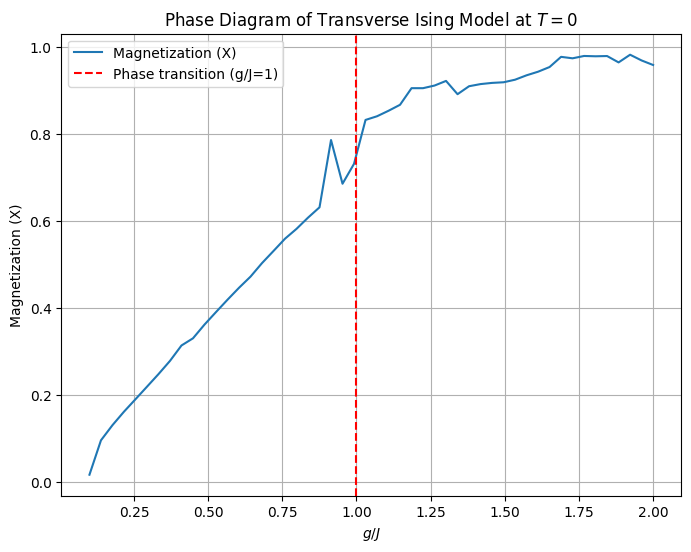

In [17]:
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit.circuit.library import TwoLocal
from qiskit import QuantumCircuit
from scipy.optimize import minimize
from numpy.linalg import eigvalsh
from qiskit.primitives import StatevectorEstimator as Estimator
import numpy as np
import time
import matplotlib.pyplot as plt
from itertools import combinations

# Define the Estimator
estimator = Estimator()

# Transverse Ising Model Hamiltonian construction
def construct_ising_hamiltonian(num_qubits, g, J):
    terms = []

    # Add ZZ interaction terms
    for i in range(num_qubits - 1):
        zz_term = ['I'] * num_qubits
        zz_term[i] = 'Z'
        zz_term[i + 1] = 'Z'
        terms.append((''.join(zz_term), -J))  # ZZ interaction (negative sign for consistency)

    # Add X terms (Transverse field)
    for i in range(num_qubits):
        x_term = ['I'] * num_qubits
        x_term[i] = 'X'
        terms.append((''.join(x_term), -g))  # X field (negative sign for consistency)

    # Construct Hamiltonian using SparsePauliOp
    hamiltonian = SparsePauliOp.from_list(terms)
    return hamiltonian

# Define the cost function for VQE
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs
    return cost

# Create an ansatz circuit
def create_ansatz(num_qubits):
    ansatz = TwoLocal(num_qubits, ['rz', 'ry'], 'cx', 'linear', reps=2)
    return ansatz

# Compute magnetization in X direction
def compute_magnetization(ground_state, num_qubits):
    magnetization_x = 0
    for i in range(num_qubits):
        x_op = Pauli('I' * i + 'X' + 'I' * (num_qubits - i - 1))
        expectation_value = ground_state.expectation_value(SparsePauliOp(x_op)).real
        magnetization_x += expectation_value
    return magnetization_x / num_qubits

# VQE simulation function
def run_vqe(num_qubits, g, J):
    # Construct Hamiltonian
    hamiltonian = construct_ising_hamiltonian(num_qubits, g, J)

    # Create ansatz
    ansatz = create_ansatz(num_qubits)

    # Initial parameters
    x0 = np.ones(ansatz.num_parameters)

    # Run VQE
    result = minimize(cost_func_vqe, x0, args=(ansatz, hamiltonian, estimator), method='COBYLA', options={'maxiter': 500})

    return result

# Parameters
num_qubits = 4  # Number of qubits
J = 1.0  # Interaction constant
g_values = np.linspace(0.1, 2.0, 50)  # Range of g values

magnetizations = []

# Run VQE for different g values and calculate magnetization
for g in g_values:
    result = run_vqe(num_qubits, g, J)

    # Ground state energy (from VQE)
    print(f"VQE minimum energy for g/J={g/J}: {result.fun}")

    # Construct ground state from VQE parameters and ansatz
    ansatz = create_ansatz(num_qubits)
    params = result.x

    from qiskit.quantum_info import Statevector
# Bind the parameters to the ansatz
    bound_ansatz = ansatz.assign_parameters(params)

# Get the statevector corresponding to the ansatz with the optimal parameters
    ground_state = Statevector(bound_ansatz)

# Now compute magnetization using the correct statevector
    magnetization_x = compute_magnetization(ground_state, num_qubits)
    magnetizations.append(magnetization_x)

    print(f"Magnetization for g/J={g/J}: {magnetization_x}")

# Plot the phase diagram
plt.figure(figsize=(8, 6))
plt.plot(g_values / J, magnetizations, label="Magnetization (X)")
plt.axvline(1, color='r', linestyle='--', label='Phase transition (g/J=1)')
plt.xlabel(r'$g/J$')
plt.ylabel('Magnetization (X)')
plt.title('Phase Diagram of Transverse Ising Model at $T=0$')
plt.legend()
plt.grid(True)
plt.show()
